#  Предсказание найма кандитата на должность

## 1. Описание задания
На основании данный из  дата-сета (https://www.kaggle.com/shivan118/hranalysis?select=train.csv (test.csv - предварительно скачен)) необходимо определить (предсказать) факт найма потенциального сотрудника.

## 2. Описание предметной области

В общем случае на множесте данны определы 12(13*) признаков. Проведём описание столбцов таблицы:
1. employee_id = ID-записи в таблице;
2. department = наименование департамента, куда рассматривалась кандидатура потенциального сотрудника;
3. region = наименование (обезличенное) региона, откуда поступила кандидатура;
4. education = уровень образования кандидиата (бакалавр, магистр, и т.д.);
5. gender = пол (муж/жен) кандидата;
6. recruitment_channel = канал подбора персонала;
7. no_of_trainings = колличество пройденных тренингов;
8. age = возраст кандидата
9. previous_year_rating = прошлогодний рейтинг сотрудника (в компании);
10. length of service = стаж работы;
11. KPIs_met >80% = "ключевой показатель эффективности";
12. awards_won? = победитель номинаций/конкурсов;
13. avg_training_score = средняя оценка в рамках прохождений курсов;
14. is_promoted * = был ли нанят сотрудник (* - используется в тренировочной выборке).


In [4]:
import numpy as np              # Массивы (матрицы, векторы, линейная алгебра)
import matplotlib.pyplot as plt # Научная графика
%matplotlib inline 
# Говорим jupyter'у, чтобы весь графический вывод был в браузере, а не в отдельном окне
import pandas as pd             # Таблицы и временные ряды (dataframe, series)
import seaborn as sns           # Еще больше красивой графики для визуализации данных
import sklearn                  # Алгоритмы машинного обучения

In [5]:
# Считываем данные с локального файла
url = "train.csv"
data_raw=pd.read_csv(url)

In [6]:
# Узнаем размер таблицы
data_raw.shape

(54808, 14)

In [7]:
# Выведем первые 5 строк таблицы
data_raw.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


### Типы признаков (столбцов)
1. employee_id = числовой;
2. department = категориальный;
3. region = категориальный;
4. education = категориальный;
5. gender = бинарный;
6. recruitment_channel = категориальный;
7. no_of_trainings = числовой;
8. age = числовой;
9. previous_year_rating = числовой;
10. length of service = числовой;
11. KPIs_met >80% = бинарный;
12. awards_won? = бинарный;
13. avg_training_score = числовой;
14. is_promoted * = бинарный.

# Подготовка данных

### Убираем выбросы

In [14]:
rows_to_drop = data_raw[
    (data_raw['length_of_service'] < data_raw['length_of_service'].quantile(0.005)) | (data_raw['length_of_service'] > data_raw['length_of_service'].quantile(0.995)) | 
    (data_raw['age']  < data_raw['age' ].quantile(0.005)) | (data_raw['age']  > data_raw['age' ].quantile(0.995)) | 
    (data_raw['avg_training_score']  < data_raw['avg_training_score' ].quantile(0.005)) | (data_raw['avg_training_score']  > data_raw['avg_training_score' ].quantile(0.995))].index
data = data_raw.drop(rows_to_drop)
data.shape

(53695, 14)

### Заполнение пропущенных значений

In [15]:
data.isna().sum()

employee_id                0
department                 0
region                     0
education               2315
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    3982
length_of_service          0
KPIs_met >80%              0
awards_won?                0
avg_training_score         0
is_promoted                0
dtype: int64

Как видно из результата - в дата-сете отсутсвуют записи по двум признакам: education (категориальный) - 2315 записей и previous_year_rating (числовой) - 3982.

Всего в тренировочоном дата сете представлено около 52 тысяч записей - 2315+3982= записи это ~12%.
Есть два пути решения - или заполнить данные средним или медианной, или удалим эти строки. Второй вариант возможен, но идти этим путем не интересно :)

Попробуем заполнить их медианной (для числового признака):

In [16]:
data.fillna(data.median(axis = 0), axis=0 , inplace=True)
data.isna().sum()

employee_id                0
department                 0
region                     0
education               2315
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating       0
length_of_service          0
KPIs_met >80%              0
awards_won?                0
avg_training_score         0
is_promoted                0
dtype: int64

Столбец с категориальным признаком заполним модой:

In [17]:
data['education'].fillna(data['education'].mode().iloc[0], inplace=True)
data.isna().sum()

employee_id             0
department              0
region                  0
education               0
gender                  0
recruitment_channel     0
no_of_trainings         0
age                     0
previous_year_rating    0
length_of_service       0
KPIs_met >80%           0
awards_won?             0
avg_training_score      0
is_promoted             0
dtype: int64

In [18]:
data.describe()

,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
count,53695.000000,53695.000000,53695.000000,53695.000000,53695.000000,53695.000000,53695.000000,53695.000000,53695.000000
mean,39185.435515,1.253841,34.678555,3.303287,5.767148,0.352174,0.022293,63.392066,0.082224
std,22595.327963,0.609429,7.367058,1.215134,3.994236,0.477652,0.147635,13.190104,0.274708
min,1.000000,1.000000,22.000000,1.000000,1.000000,0.000000,0.000000,44.000000,0.000000
25%,19657.000000,1.000000,29.000000,3.000000,3.000000,0.000000,0.000000,51.000000,0.000000
50%,39187.000000,1.000000,33.000000,3.000000,5.000000,0.000000,0.000000,60.000000,0.000000
75%,58740.000000,1.000000,39.000000,4.000000,7.000000,1.000000,0.000000,76.000000,0.000000
max,78298.000000,10.000000,59.000000,5.000000,24.000000,1.000000,1.000000,94.000000,1.000000


### Бинаризация номинальных признаков
Признаки:
KPIs_met >80% = бинарный;
awards_won? = бинарный;
is_promoted = бинарный;
gender = бинарный

In [19]:
data['KPIs_met >80%'] = pd.factorize(data['KPIs_met >80%'])[0]
data['awards_won?'] = pd.factorize(data['awards_won?'])[0]
data['is_promoted'] = pd.factorize(data['is_promoted'])[0]
data['gender'] = pd.factorize(data['gender'])[0]

### Бинаризация категориальных признаков
Признаки:
department;
region;
education;
gender;
recruitment_channel.


In [20]:
department_dummies = pd.get_dummies(data['department'])
data = pd.concat((data, department_dummies), axis=1)
data = data.drop(['department'], axis=1)
department_dummies.head()

,Analytics,Finance,HR,Legal,Operations,Procurement,R&D,Sales & Marketing,Technology
0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,1


In [21]:
region_dummies = pd.get_dummies(data['region'])
data = pd.concat((data, region_dummies), axis=1)
data = data.drop(['region'], axis=1)
region_dummies.head()

,region_1,region_10,region_11,region_12,region_13,region_14,region_15,region_16,region_17,region_18,...,region_31,region_32,region_33,region_34,region_4,region_5,region_6,region_7,region_8,region_9
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
education_dummies = pd.get_dummies(data['education'])
data = pd.concat((data, education_dummies), axis=1)
data = data.drop(['education'], axis=1)
education_dummies.head()

,Bachelor's,Below Secondary,Master's & above
0,0,0,1
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


In [23]:
recruitment_channel_dummies = pd.get_dummies(data['recruitment_channel'])
data = pd.concat((data, recruitment_channel_dummies), axis=1)
data = data.drop(['recruitment_channel'], axis=1)
recruitment_channel_dummies.head()

,other,referred,sourcing
0,0,0,1
1,1,0,0
2,0,0,1
3,1,0,0
4,1,0,0


### Нормализация колличественных признаков

In [24]:
data_stand = (data - data.mean(axis = 0))/data.std(axis = 0)
data_stand.describe()

,employee_id,gender,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,...,region_6,region_7,region_8,region_9,Bachelor's,Below Secondary,Master's & above,other,referred,sourcing
count,5.369500e+04,5.369500e+04,5.369500e+04,5.369500e+04,5.369500e+04,5.369500e+04,5.369500e+04,5.369500e+04,5.369500e+04,5.369500e+04,...,5.369500e+04,5.369500e+04,5.369500e+04,5.369500e+04,5.369500e+04,5.369500e+04,5.369500e+04,5.369500e+04,5.369500e+04,5.369500e+04
mean,2.249600e-17,-1.249396e-16,2.230269e-15,-6.283786e-16,-1.929950e-15,1.326344e-16,2.375230e-16,1.001266e-15,3.361167e-17,-2.212128e-15,...,-4.279202e-16,1.626711e-15,4.197447e-16,-6.483782e-16,7.007958e-16,-3.564925e-15,1.258105e-15,7.660942e-16,2.630568e-15,2.052657e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.734183e+00,-1.536054e+00,-4.165230e-01,-1.720979e+00,-1.895500e+00,-1.193507e+00,-1.356270e+00,-1.509982e-01,-1.470198e+00,-2.993133e-01,...,-1.133377e-01,-3.123127e-01,-1.106094e-01,-8.868234e-02,-1.585857e+00,-1.161697e-01,-6.099784e-01,-1.116652e+00,-1.469489e-01,-8.578081e-01
25%,-8.642687e-01,-1.536054e+00,-4.165230e-01,-7.708036e-01,-2.495914e-01,-6.927853e-01,-1.356270e+00,-1.509982e-01,-9.394972e-01,-2.993133e-01,...,-1.133377e-01,-3.123127e-01,-1.106094e-01,-8.868234e-02,-1.585857e+00,-1.161697e-01,-6.099784e-01,-1.116652e+00,-1.469489e-01,-8.578081e-01
50%,6.923930e-05,6.510065e-01,-4.165230e-01,-2.278460e-01,-2.495914e-01,-1.920637e-01,7.373025e-01,-1.509982e-01,-2.571675e-01,-2.993133e-01,...,-1.133377e-01,-3.123127e-01,-1.106094e-01,-8.868234e-02,6.305619e-01,-1.161697e-01,-6.099784e-01,8.955175e-01,-1.469489e-01,-8.578081e-01
75%,8.654251e-01,6.510065e-01,-4.165230e-01,5.865903e-01,5.733628e-01,3.086579e-01,7.373025e-01,-1.509982e-01,9.558631e-01,-2.993133e-01,...,-1.133377e-01,-3.123127e-01,-1.106094e-01,-8.868234e-02,6.305619e-01,-1.161697e-01,1.639372e+00,8.955175e-01,-1.469489e-01,1.165740e+00
max,1.731002e+00,6.510065e-01,1.435140e+01,3.301378e+00,1.396317e+00,4.564791e+00,7.373025e-01,6.622474e+00,2.320523e+00,3.340919e+00,...,8.823029e+00,3.201860e+00,9.040656e+00,1.127599e+01,6.305619e-01,8.607934e+00,1.639372e+00,8.955175e-01,6.804962e+00,1.165740e+00


## Отбор признаков

In [25]:
data_stand.columns

Index(['employee_id', 'gender', 'no_of_trainings', 'age',
       'previous_year_rating', 'length_of_service', 'KPIs_met >80%',
       'awards_won?', 'avg_training_score', 'is_promoted', 'Analytics',
       'Finance', 'HR', 'Legal', 'Operations', 'Procurement', 'R&D',
       'Sales & Marketing', 'Technology', 'region_1', 'region_10', 'region_11',
       'region_12', 'region_13', 'region_14', 'region_15', 'region_16',
       'region_17', 'region_18', 'region_19', 'region_2', 'region_20',
       'region_21', 'region_22', 'region_23', 'region_24', 'region_25',
       'region_26', 'region_27', 'region_28', 'region_29', 'region_3',
       'region_30', 'region_31', 'region_32', 'region_33', 'region_34',
       'region_4', 'region_5', 'region_6', 'region_7', 'region_8', 'region_9',
       'Bachelor's', 'Below Secondary', 'Master's & above', 'other',
       'referred', 'sourcing'],
      dtype='object')

In [177]:
X = data_stand.drop(['employee_id', 'is_promoted'], axis=1).iloc[0:5000,]
y = data['is_promoted'].iloc[0:5000,]

## Разобъем данные на обучаемую и тестовую выборку:

In [178]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

N_train, _ = X_train.shape 
N_test,  _ = X_test.shape 

N_train, N_test

(3750, 1250)

## Обучаем классификатор 

In [179]:
from sklearn.neural_network import MLPClassifier

In [180]:
mlp_model = MLPClassifier(hidden_layer_sizes = (200,),
                          solver = 'lbfgs', 
                          activation = 'logistic',
                          random_state = 42)

In [181]:
%%time
mlp_model.fit(X_train, y_train)

Wall time: 2.65 s


MLPClassifier(activation='logistic', hidden_layer_sizes=(200,), random_state=42,
              solver='lbfgs')

## Попробуем классифицировать

### Пример из тестовой выборки

In [182]:
test_data = X_test.iloc[13,]
print(y_test.iloc[13,])
mlp_model.predict([test_data])

0


array([0], dtype=int64)

In [183]:
test_data = X_test.iloc[12,]
print(y_test.iloc[12,])
mlp_model.predict([test_data])

0


array([0], dtype=int64)

## Проверяем качество классификатора

In [184]:
y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)

### Ошибка на обучающих и тестовых выборках. Метод 1

In [185]:
print("Ошибка: ", np.mean(y_train != y_train_pred), np.mean(y_test != y_test_pred))

Ошибка:  0.0 0.124


### Ошибка на обучающих и тестовых выборках. Метод 2

In [186]:
print(mlp_model.score(X_train, y_train), mlp_model.score(X_test, y_test))
print("Ошибка: ", 1 - mlp_model.score(X_test, y_test))

1.0 0.876
Ошибка:  0.124


### Ошибка на обучающих и тестовых выборках. Метод 3

In [187]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_train, y_train_pred))
print(accuracy_score(y_test, y_test_pred))

1.0
0.876


## Подбор гипер-параметров

In [188]:
alpha_arr = np.logspace(-3, 2, 21)
test_err = []
train_err = []
train_acc = []
test_acc = []

for alpha in alpha_arr:
    mlp_model = MLPClassifier(alpha = alpha, hidden_layer_sizes = (200,), 
                              solver = 'lbfgs', activation = 'logistic', max_iter=1000, random_state = 42)
    mlp_model.fit(X_train, y_train)

    y_train_pred = mlp_model.predict(X_train)
    y_test_pred = mlp_model.predict(X_test)
    
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))
    train_acc.append(accuracy_score(y_train, y_train_pred))
    test_acc.append(accuracy_score(y_test, y_test_pred))

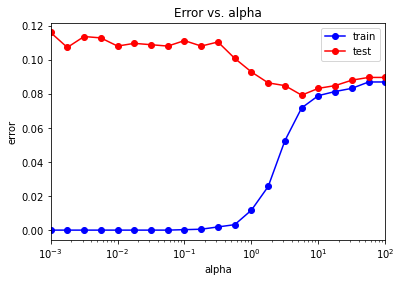

In [189]:
plt.semilogx(alpha_arr, train_err, 'b-o', label = 'train')
plt.semilogx(alpha_arr, test_err, 'r-o', label = 'test')
plt.xlim([np.min(alpha_arr), np.max(alpha_arr)])
plt.title('Error vs. alpha')
plt.xlabel('alpha')
plt.ylabel('error')
plt.legend()

### Рассмотрим как у нас менялась метрика в зависимости от гиперпараметра:

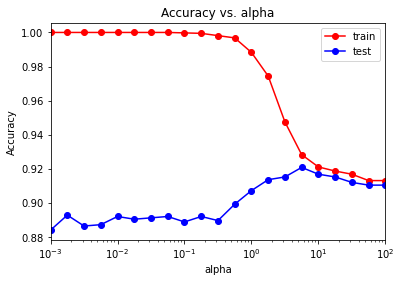

In [190]:
plt.semilogx(alpha_arr, train_acc, 'r-o', label = 'train')
plt.semilogx(alpha_arr, test_acc, 'b-o', label = 'test')
plt.xlim([np.min(alpha_arr), np.max(alpha_arr)])
plt.title('Accuracy vs. alpha')
plt.xlabel('alpha')
plt.ylabel('Accuracy')
plt.legend()

Минимальное значение ошибки

In [191]:
min_train_err = np.min(train_err)
min_test_err = np.min(test_err)
print(min_train_err, min_test_err)

0.0 0.0792


Оптимальное значение Альфа:

In [192]:
alpha_opt = alpha_arr[test_err == min_test_err]
print(alpha_opt)

[5.62341325]


## Классификатор при найденном оптимальном значении Альфа

In [193]:
### Повторим обучение

mlp_model = MLPClassifier(alpha = alpha_opt, hidden_layer_sizes = (200,),
                          solver = 'lbfgs', activation = 'logistic', random_state = 42)
mlp_model.fit(X_train, y_train)

y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)
print(np.mean(y_train != y_train_pred))
print(np.mean(y_test != y_test_pred))

0.07173333333333333
0.0792


## Матрица рассогласования и другие метрики качества

In [194]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test_pred, y_test))

[[1132   93]
 [   6   19]]


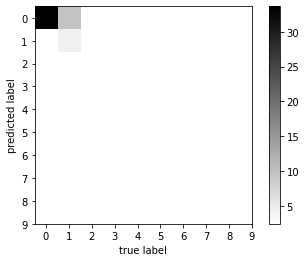

In [195]:
M = confusion_matrix(y_test_pred, y_test)
M = np.sqrt(M)
plt.imshow(M, interpolation = 'nearest')
plt.set_cmap('binary')
plt.xticks(range(10))
plt.yticks(range(10))
plt.xlabel("true label")
plt.ylabel("predicted label")
plt.colorbar()
pass

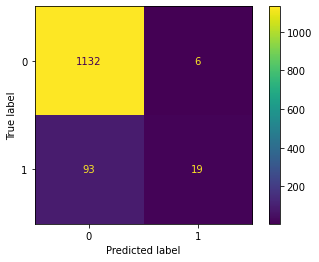

In [196]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(mlp_model, X_test, y_test) 

In [197]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.92      0.99      0.96      1138
           1       0.76      0.17      0.28       112

    accuracy                           0.92      1250
   macro avg       0.84      0.58      0.62      1250
weighted avg       0.91      0.92      0.90      1250

